<a href="https://colab.research.google.com/github/RobinMikeal/Geol558/blob/main/Copy_of_Geol558__Proj_2_Supervised_Classification_ML_Final_Cut_Robin_Mikeal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gemstone Classification using Supervised Classification Techniques on Images
Robin Mikeal:  
Geol 558, Project 2, Spring 2025
#Abstract

Mineral image classification can be helpful for quick comparative studies of different mineral photographs.  This notebook demonstrates the use of two different models and some tips and considerations that may help to improve the overall score for each.

#Intro

This project will evaluate the effectiveness of different supervised classification techniques on mineral images.  This is not considered big data.  This is actually a fairly small dataset of about 3000 images curated on Kaggle by Daria Chemkaeva from minerals.net and www.rasavgems.com websites. My goal is to see how effective variations in the data (image size, presence of background, variety of images content such as shape) affects the classification.

#Installs and Imports

#**Use high ram runtime, with a T4 GPU**

In [48]:
import tensorflow as tf
import torch
import torchvision
import numpy as np
from tensorflow import keras
# Print versions
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"NumPy Version: {np.__version__}")
# Check TensorFlow GPU
print("\nTensorFlow GPU Available:", bool(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow GPU Devices:", tf.config.list_physical_devices('GPU'))
# Check PyTorch GPU
print("\nPyTorch GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("PyTorch GPU Device:", torch.cuda.get_device_name(0))

import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import random
import cv2
import itertools
from matplotlib.colors import to_hex
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from random import randint


TensorFlow Version: 2.18.0
Keras Version: 3.8.0
PyTorch Version: 2.5.1+cu124
Torchvision Version: 0.20.1+cu124
NumPy Version: 1.26.4

TensorFlow GPU Available: True
TensorFlow GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

PyTorch GPU Available: True
PyTorch GPU Device: NVIDIA L4


#2.0 Data Loading

This data was attained from Kaggle.

In [49]:
gemstones_images_path = kagglehub.dataset_download('lsind18/gemstones-images')

In [50]:
directory = gemstones_images_path + '/train'
#printing all the gemstone categories present in our dataset
Name=[]
for file in os.listdir(directory):
    Name+=[file] # This loop now appends each gemstone category only once
print("The gemsstones in the dataset are \n")
print(Name)
print("\n The count of the gemstones categories: ",len(Name))

gems_map = dict(zip(Name, [t for t in range(len(Name))]))
print(gems_map)
r_gems_map=dict(zip([t for t in range(len(Name))],Name))

The gemsstones in the dataset are 

['Malachite', 'Pearl', 'Coral', 'Opal', 'Quartz Smoky', 'Chrysoprase', 'Onyx Green', 'Kunzite', 'Beryl Golden', 'Labradorite', 'Amber', 'Fluorite', 'Onyx Black', 'Rhodonite', 'Ruby', 'Chrome Diopside', 'Pyrope', 'Cats Eye', 'Tigers Eye', 'Tanzanite', 'Chalcedony', 'Carnelian', 'Aventurine Green', 'Topaz', 'Rhodolite', 'Citrine', 'Amethyst', 'Sapphire Yellow', 'Spessartite', 'Dumortierite', 'Moonstone', 'Danburite', 'Chrysocolla', 'Sapphire Purple', 'Quartz Rutilated', 'Tsavorite', 'Sodalite', 'Quartz Rose', 'Chrysoberyl', 'Chalcedony Blue', 'Kyanite', 'Diamond', 'Spodumene', 'Serpentine', 'Jade', 'Pyrite', 'Scapolite', 'Onyx Red', 'Hiddenite', 'Blue Lace Agate', 'Andradite', 'Garnet Red', 'Jasper', 'Andalusite', 'Variscite', 'Aquamarine', 'Iolite', 'Diaspore', 'Sapphire Blue', 'Ametrine', 'Rhodochrosite', 'Alexandrite', 'Lapis Lazuli', 'Peridot', 'Sunstone', 'Spinel', 'Quartz Lemon', 'Goshenite', 'Zoisite', 'Zircon', 'Bixbite', 'Tourmaline', 'Benitoi

In [51]:
gems_map = dict(zip(Name, [t for t in range(len(Name))]))
print(gems_map)
r_gems_map=dict(zip([t for t in range(len(Name))],Name))

{'Malachite': 0, 'Pearl': 1, 'Coral': 2, 'Opal': 3, 'Quartz Smoky': 4, 'Chrysoprase': 5, 'Onyx Green': 6, 'Kunzite': 7, 'Beryl Golden': 8, 'Labradorite': 9, 'Amber': 10, 'Fluorite': 11, 'Onyx Black': 12, 'Rhodonite': 13, 'Ruby': 14, 'Chrome Diopside': 15, 'Pyrope': 16, 'Cats Eye': 17, 'Tigers Eye': 18, 'Tanzanite': 19, 'Chalcedony': 20, 'Carnelian': 21, 'Aventurine Green': 22, 'Topaz': 23, 'Rhodolite': 24, 'Citrine': 25, 'Amethyst': 26, 'Sapphire Yellow': 27, 'Spessartite': 28, 'Dumortierite': 29, 'Moonstone': 30, 'Danburite': 31, 'Chrysocolla': 32, 'Sapphire Purple': 33, 'Quartz Rutilated': 34, 'Tsavorite': 35, 'Sodalite': 36, 'Quartz Rose': 37, 'Chrysoberyl': 38, 'Chalcedony Blue': 39, 'Kyanite': 40, 'Diamond': 41, 'Spodumene': 42, 'Serpentine': 43, 'Jade': 44, 'Pyrite': 45, 'Scapolite': 46, 'Onyx Red': 47, 'Hiddenite': 48, 'Blue Lace Agate': 49, 'Andradite': 50, 'Garnet Red': 51, 'Jasper': 52, 'Andalusite': 53, 'Variscite': 54, 'Aquamarine': 55, 'Iolite': 56, 'Diaspore': 57, 'Sapphi

This dataset was already grouped in Train and Test datasubfolders.  A summary of each subfolder name and the number of images for each subbfolder, and a total sum of images is provided for the test and train data below in a data frame.

In [52]:
# Define the directory path
directorytest = gemstones_images_path + '/test'  # Update this path based on your extracted dataset structure
# Initialize a dictionary to store the count of jpg files in each subfolder
subfolder_counts = {}

# Define the directory path
directorytrain = gemstones_images_path + '/train'  # Update this path based on your extracted dataset structure
# Initialize a dictionary to store the count of jpg files in each subfolder
subfolder_counts = {}

train_counts = {}
for root, dirs, files in os.walk(directorytrain):
    for subfolder in dirs:
        subfolder_path = os.path.join(root, subfolder)
        jpg_count = len([file for file in os.listdir(subfolder_path) if file.endswith('.jpg')])
        train_counts[subfolder] = jpg_count

test_counts = {}
for root, dirs, files in os.walk(directorytest):
    for subfolder in dirs:
        subfolder_path = os.path.join(root, subfolder)
        jpg_count = len([file for file in os.listdir(subfolder_path) if file.endswith('.jpg')])
        test_counts[subfolder] = jpg_count


data = []
for mineral in train_counts:
  data.append([mineral, train_counts[mineral], test_counts.get(mineral,0)])

df = pd.DataFrame(data, columns=['Mineral', 'TrainCount', 'TestCount'])

df['TrnTstSplitRatio'] = df['TrainCount']/(df['TrainCount'] + df['TestCount'])

df

,Mineral,TrainCount,TestCount,TrnTstSplitRatio
0,Malachite,28,4,0.875000
1,Pearl,33,4,0.891892
2,Coral,31,4,0.885714
3,Opal,36,5,0.878049
4,Quartz Smoky,30,4,0.882353
...,...,...,...,...
82,Quartz Beer,35,4,0.897436
83,Grossular,29,4,0.878788
84,Bloodstone,35,4,0.897436
85,Emerald,36,5,0.878049


In [53]:
print(df.shape)
df.describe().round(2)

(87, 4)


,TrainCount,TestCount,TrnTstSplitRatio
count,87.00,87.00,87.00
mean,32.83,4.17,0.89
std,3.69,0.38,0.01
min,27.00,4.00,0.87
25%,30.00,4.00,0.88
50%,32.00,4.00,0.89
75%,35.00,4.00,0.89
max,45.00,5.00,0.90


In [54]:
train_sum = df['TrainCount'].sum()
test_sum = df['TestCount'].sum()
avg_ratio = df['TrnTstSplitRatio'].mean()

print(f"Sum of TrainCount: {train_sum}")
print(f"Sum of TestCount: {test_sum}")
print(f"Average of TrnTstSplitRatio: {avg_ratio:.2f}")

Sum of TrainCount: 2856
Sum of TestCount: 363
Average of TrnTstSplitRatio: 0.89


The total number of images is 3,219.  There are 87 unique gemstones in both the test and the train dataset.  Let's display a histogram of all of the counts of jpgs within the unique subfolders of directorytrain to get a sense of the number of images per stone type.

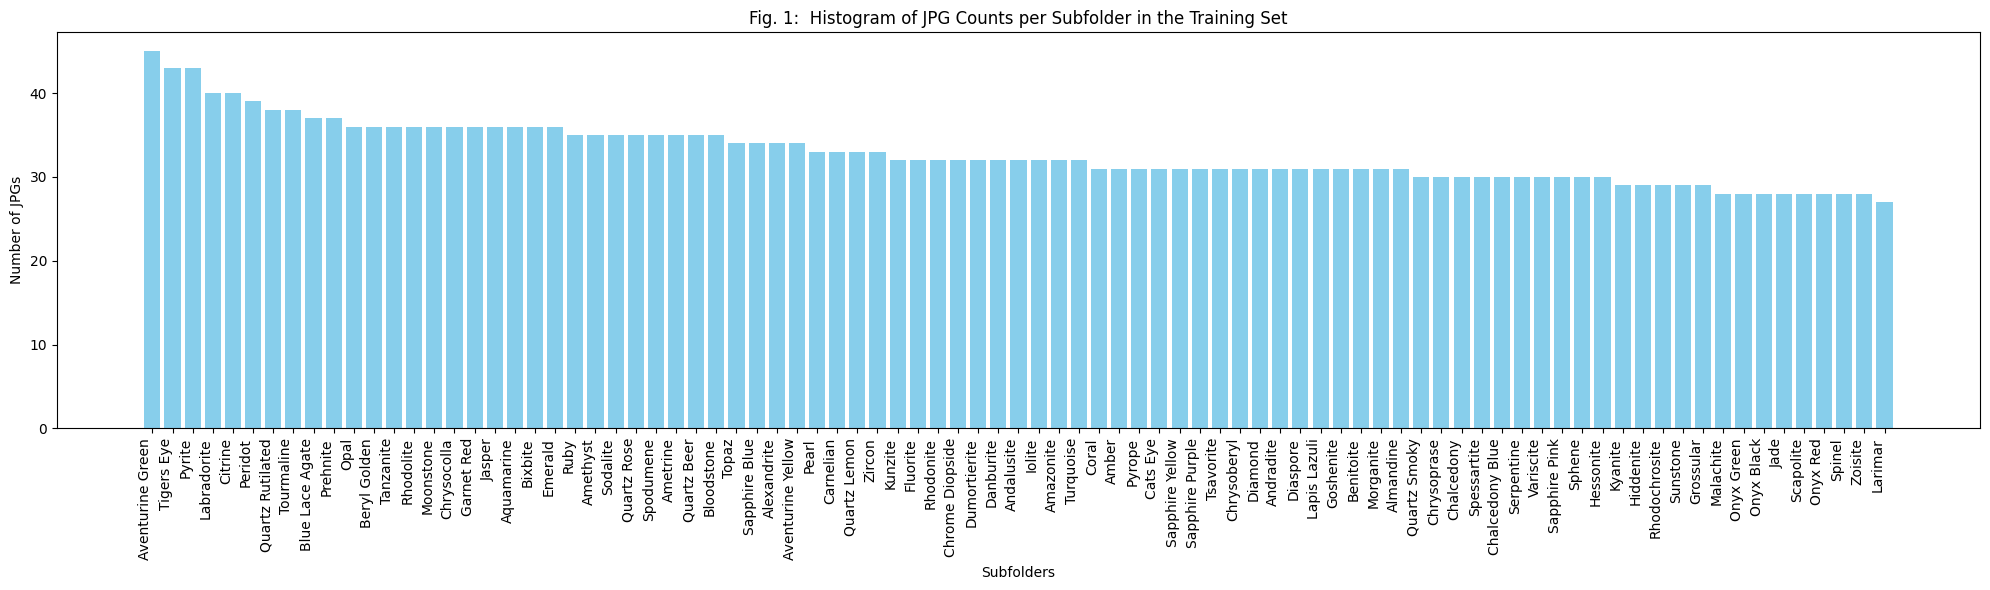

In [55]:
subfolder_counts = {}
for root, dirs, files in os.walk(directorytrain):
    for subfolder in dirs:
        subfolder_path = os.path.join(root, subfolder)
        jpg_count = len([file for file in os.listdir(subfolder_path) if file.endswith('.jpg')])
        subfolder_counts[subfolder] = jpg_count

# Sort subfolders by image count in descending order
sorted_subfolders = sorted(subfolder_counts, key=subfolder_counts.get, reverse=True)
sorted_counts = [subfolder_counts[subfolder] for subfolder in sorted_subfolders]


# Create the histogram
plt.figure(figsize=(20, 6))  # Adjust figure size as needed
plt.bar(sorted_subfolders, sorted_counts, color='skyblue')
plt.xlabel("Subfolders")
plt.ylabel("Number of JPGs")
plt.title("Fig. 1:  Histogram of JPG Counts per Subfolder in the Training Set")
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

#Scatter Plot of Image Sizes

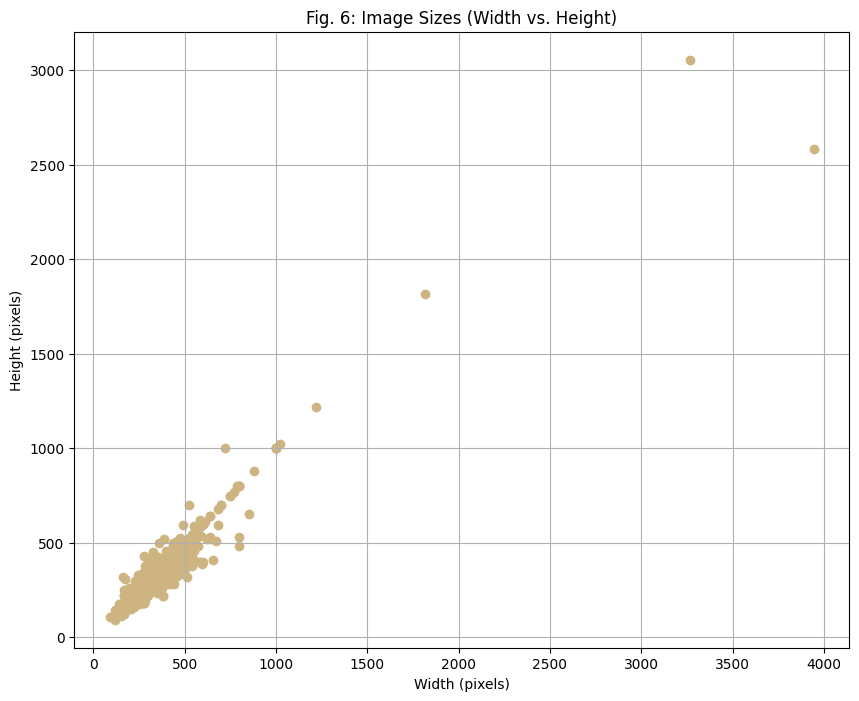

In [56]:
def plot_image_sizes(directory):
  """
  Creates a scatter plot of image sizes (width vs. height) for images in subfolders.

  Args:
      directory: The path to the directory containing subfolders with images.
  """
  widths = []
  heights = []
  labels = []

  for subfolder_name in os.listdir(directory):
    subfolder_path = os.path.join(directory, subfolder_name)
    if os.path.isdir(subfolder_path):
      for filename in os.listdir(subfolder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
          image_path = os.path.join(subfolder_path, filename)
          try:
            image = cv2.imread(image_path)
            height, width, _ = image.shape  # Get height and width
            widths.append(width)
            heights.append(height)
            labels.append(subfolder_name)
          except Exception as e:
            print(f"Error loading image {image_path}: {e}")

  plt.figure(figsize=(10, 8))
  plt.scatter(widths, heights)
  plt.xlabel("Width (pixels)")
  plt.ylabel("Height (pixels)")
  plt.title("Fig. 6: Image Sizes (Width vs. Height)")
  plt.grid(True)
  plt.show()

plot_image_sizes(directorytrain)

There are definitely some large image sizes that might through off the machine learning later on.  We can find out which ones are greater than a threshold of size.  The code below will provide the names of the minerals that are greater than 1500 pixels in width.

In [57]:
def print_large_images(directory, min_width=1500):
    for subfolder_name in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder_name)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(subfolder_path, filename)
                    try:
                        image = cv2.imread(image_path)
                        height, width, _ = image.shape
                        if width > min_width:
                            print(filename)
                    except Exception as e:
                        print(f"Error loading image {image_path}: {e}")

directorytrain = gemstones_images_path + '/train'
print_large_images(directorytrain)

chrysocolla_1.jpg
chrysocolla_5.jpg
chrysocolla_7.jpg


Some of these larger images might need to be removed if the test data set has mismatches associated with chrysocolla.  Alternatively, we could simply resize all the images to be 100 x 100, this may also help with performance of the models. We'll also prepare some functions that will be useful in machine learning later in the codebook as well, but we won't call those functions yet.  These functions are going to resize the images, change the colors to RGB values, and change the names of the categorical (string) subfolder names of each mineral to be numbers.

In [58]:
img_w, img_h = 100, 100

In [59]:
#function which reads images and class names
def read_images():
    Images, Labels = [], []
    for root, dirs, files in os.walk(directorytrain):
        f = os.path.basename(root)
        for file in files:
            Labels.append(f)
            try:
                image = cv2.imread(root+'/'+file)              # read the image (OpenCV)
                # Get image dimensions
                height, width, _ = image.shape
                # Calculate center coordinates for cropping
                center_x = width // 2
                center_y = height // 2
                # Calculate cropping dimensions (half of original size)
                crop_width = width // 2
                crop_height = height // 2
                # Crop the image
                cropped_image = image[center_y - crop_height // 2:center_y + crop_height // 2,
                                     center_x - crop_width // 2:center_x + crop_width // 2]
                # Resize the cropped image to 100x100
                resized_image = cv2.resize(cropped_image,(int(img_w), int(img_h)))
                # Convert the image from BGR to RGB
                image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
                Images.append(image_rgb)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    return (Images,Labels)

In [60]:
#function which converts string labels to numbers
def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(Name):
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels

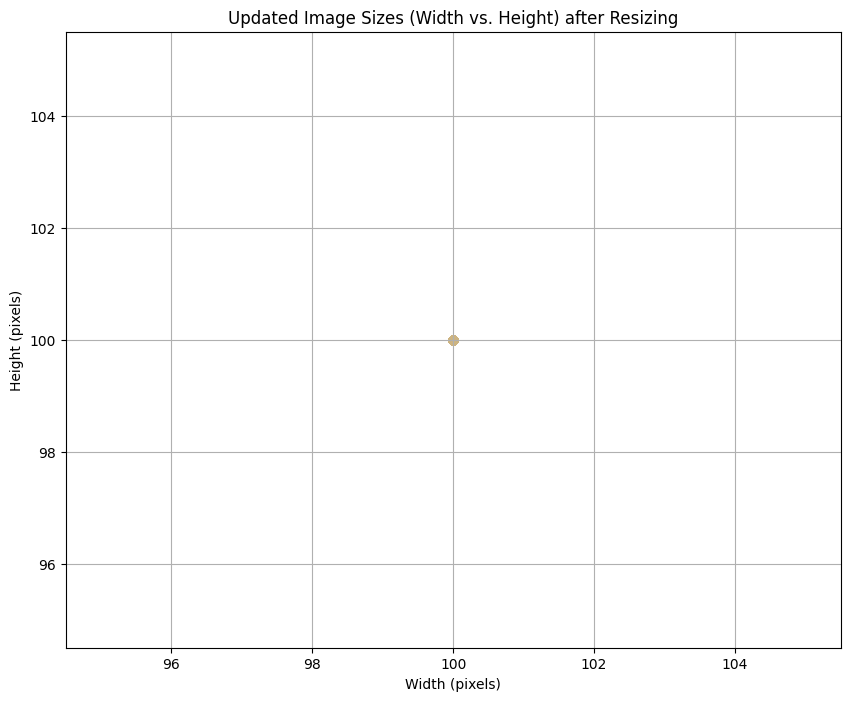

In [61]:
def process_and_plot_images(directory):
    Images, Labels = read_images()  # Assuming read_images modifies images in directorytrain
    Labels = get_class_index(Labels) # Assuming get_class_index modifies Labels

    # Now you have resized images (in Images array) and numerical labels.

    # Create the scatter plot of image sizes
    widths = []
    heights = []
    for image in Images:
        height, width, _ = image.shape
        widths.append(width)
        heights.append(height)

    plt.figure(figsize=(10, 8))
    plt.scatter(widths, heights)
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.title("Updated Image Sizes (Width vs. Height) after Resizing")
    plt.grid(True)
    plt.show()


process_and_plot_images(directory)


Next let's take a sneak peak of some random images from directorytrain with labels just to check to make sure the files look good.

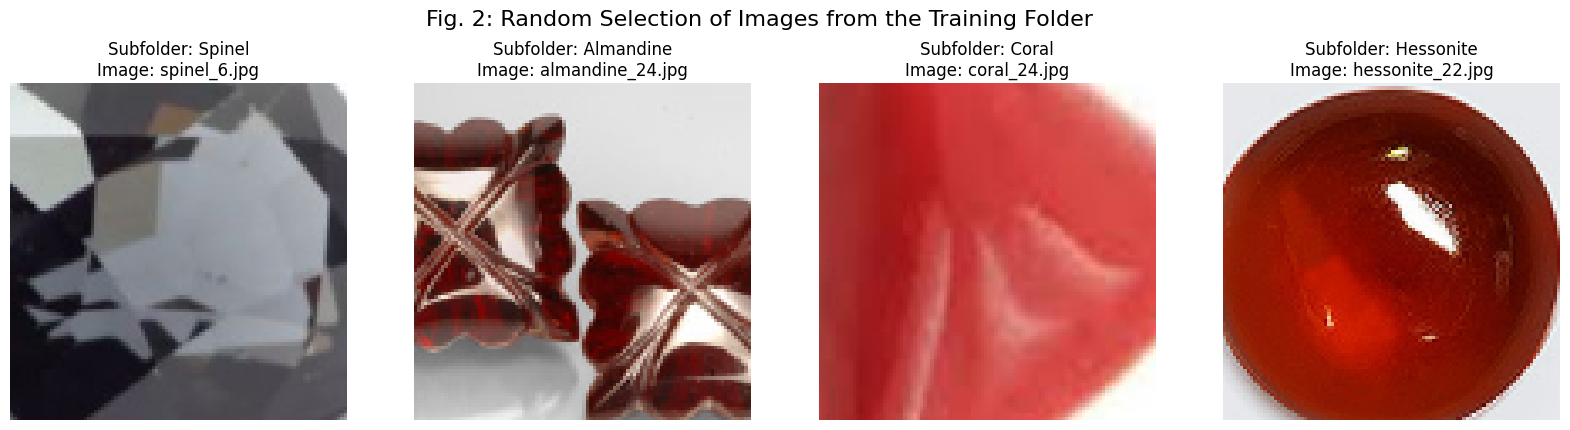

In [62]:
# Get a list of all subfolders in the directory
subfolders = [f.name for f in os.scandir(directorytrain) if f.is_dir()]
# Select 4 random subfolders
selected_subfolders = random.sample(subfolders, min(4, len(subfolders)))
# Create a figure and axes for the images
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Fig. 2: Random Selection of Images from the Training Folder', fontsize=16)
# Loop through the selected subfolders and display one random image from each
for i, subfolder in enumerate(selected_subfolders):
    subfolder_path = os.path.join(directorytrain, subfolder)
    image_files = [f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if image_files:
        random_image = random.choice(image_files)
        image_path = os.path.join(subfolder_path, random_image)

        # Read and process the image using the updated read_images function
        try:
          image = cv2.imread(image_path)
          # Get image dimensions
          height, width, _ = image.shape
          # Calculate center coordinates for cropping
          center_x = width // 2
          center_y = height // 2
          # Calculate cropping dimensions (half of original size)
          crop_width = width // 2
          crop_height = height // 2
          # Crop the image
          cropped_image = image[center_y - crop_height // 2:center_y + crop_height // 2,
                               center_x - crop_width // 2:center_x + crop_width // 2]
          # Resize the cropped image to 100x100
          resized_image = cv2.resize(cropped_image,(int(img_w), int(img_h)))
          # Convert the image from BGR to RGB
          img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
          axes[i].imshow(img)
          axes[i].set_title(f"Subfolder: {subfolder}\nImage: {random_image}")
          axes[i].axis('off')
        except Exception as e:
          print(f"Error processing image {image_path}: {e}")
          axes[i].text(0.5, 0.5, f"Error loading image", ha='center', va='center')
          axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, f"No images in {subfolder}", ha='center', va='center')
        axes[i].axis('off')
plt.show()


In [63]:

def analyze_subfolder_statistics(directory):
    """Calculates image statistics for each subfolder and displays color channel averages in a histogram.
    Args:
        directory: Path to the directory containing subfolders.
    """
    subfolder_statistics = {}
    for subfolder_name in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder_name)
        if os.path.isdir(subfolder_path):
            means = []
            std_devs = []
            color_histograms = []
            for filename in os.listdir(subfolder_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(subfolder_path, filename)
                    # Read and process the image using the updated read_images function
                    try:
                        image = cv2.imread(image_path)
                        # Get image dimensions
                        height, width, _ = image.shape
                        # Calculate center coordinates for cropping
                        center_x = width // 2
                        center_y = height // 2
                        # Calculate cropping dimensions (half of original size)
                        crop_width = width // 2
                        crop_height = height // 2
                        # Crop the image
                        cropped_image = image[center_y - crop_height // 2:center_y + crop_height // 2,
                                             center_x - crop_width // 2:center_x + crop_width // 2]
                        # Resize the cropped image to 100x100
                        resized_image = cv2.resize(cropped_image,(int(img_w), int(img_h)))
                        # Convert the image from BGR to RGB
                        image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

                        means.append(np.mean(image))
                        std_devs.append(np.std(image))
                        color_histograms.append(cv2.calcHist([image], [0], None, [256], [0, 256]))  # Blue channel
                    except Exception as e:
                        print(f"Error processing image {image_path}: {e}")

            if means:  # Check if any images were successfully processed
                subfolder_statistics[subfolder_name] = {
                    "avg_mean": np.mean(means),
                    "avg_std_dev": np.mean(std_devs),
                    "avg_color_histogram": np.mean(color_histograms, axis=0)  # Average color histogram
                }
    # Sort subfolders by average color channel value in decreasing order
    sorted_subfolders = sorted(subfolder_statistics.items(), key=lambda x: x[1]["avg_color_histogram"][0] if isinstance(x[1]["avg_color_histogram"], np.ndarray) and x[1]["avg_color_histogram"].size > 0 else 0, reverse=True)

    # Display color channel averages in a histogram
    subfolder_names = [item[0] for item in sorted_subfolders]
    avg_color_channels = [item[1]["avg_color_histogram"][0].item() if isinstance(item[1]["avg_color_histogram"], np.ndarray) and item[1]["avg_color_histogram"].size > 0 else 0 for item in sorted_subfolders]  # Blue channel average
    plt.figure(figsize=(20, 6))  # Adjust figure size as needed
    plt.bar(subfolder_names, avg_color_channels, color='skyblue')
    plt.xlabel("Subfolders")
    plt.ylabel("Average Color Channel Value (Blue)")
    plt.title("Fig. 3: Average Blue Channel Value per Subfolder")
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()


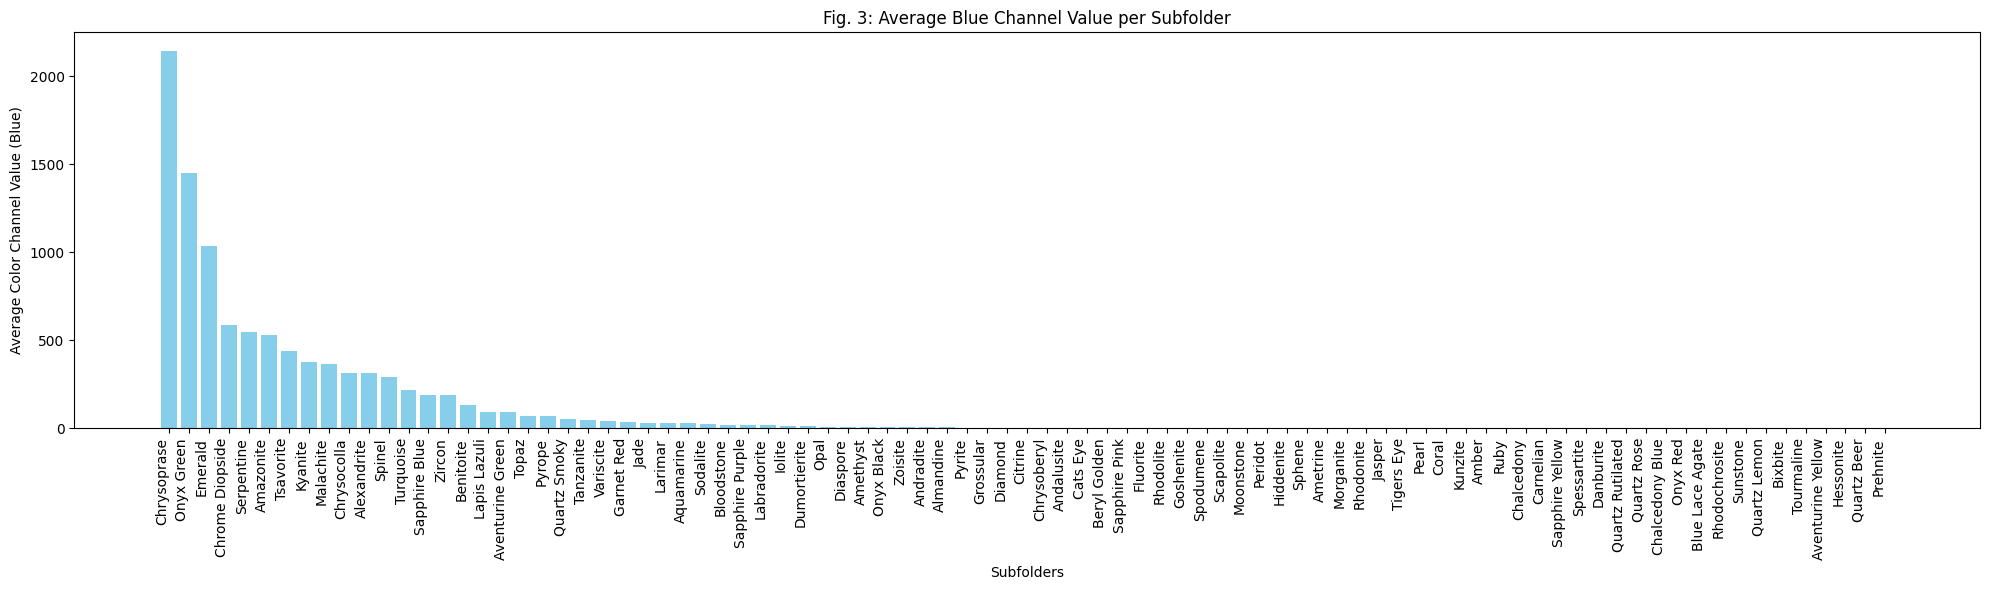

In [64]:
analyze_subfolder_statistics(directorytrain)


In [73]:
# prompt: Can you change this histogram to plot the average RGB value and have the color of each bar reflect that average RGB value?
def analyze_subfolder_statistics2(directory):
    """Calculates image statistics for each subfolder and displays color channel averages in a histogram.
    Args:
        directory: Path to the directory containing subfolders.
    """
    subfolder_statistics = {}
    for subfolder_name in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder_name)
        if os.path.isdir(subfolder_path):
            means = []
            std_devs = []
            avg_rgb_values = []
            for filename in os.listdir(subfolder_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(subfolder_path, filename)
                    # Read and process the image using the updated read_images function
                    try:
                        image = cv2.imread(image_path)
                        # Get image dimensions
                        height, width, _ = image.shape
                        # Calculate center coordinates for cropping
                        center_x = width // 2
                        center_y = height // 2
                        # Calculate cropping dimensions (half of original size)
                        crop_width = width // 2
                        crop_height = height // 2
                        # Crop the image
                        cropped_image = image[center_y - crop_height // 2:center_y + crop_height // 2,
                                             center_x - crop_width // 2:center_x + crop_width // 2]
                        # Resize the cropped image to 100x100
                        resized_image = cv2.resize(cropped_image, (100, 100))
                        # Convert the image from BGR to RGB
                        image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

                        means.append(np.mean(image_rgb))
                        std_devs.append(np.std(image_rgb))
                        avg_rgb_values.append(np.mean(image_rgb, axis=(0, 1)))  # Average RGB value
                    except Exception as e:
                        print(f"Error processing image {image_path}: {e}")

            if means:  # Check if any images were successfully processed
                subfolder_statistics[subfolder_name] = {
                    "avg_mean": np.mean(means),
                    "avg_std_dev": np.mean(std_devs),
                    "avg_rgb_value": np.mean(avg_rgb_values, axis=0)  # Average RGB value
                }

    # Sort subfolders by average RGB value in decreasing order
    sorted_subfolders = sorted(subfolder_statistics.items(), key=lambda x: np.mean(x[1]["avg_rgb_value"]) if isinstance(x[1]["avg_rgb_value"], np.ndarray) and x[1]["avg_rgb_value"].size > 0 else 0, reverse=True)

    # Display average RGB values in a histogram
    subfolder_names = [item[0] for item in sorted_subfolders]
    avg_rgb_values = [item[1]["avg_rgb_value"] for item in sorted_subfolders]

    plt.figure(figsize=(20, 6))  # Adjust figure size as needed

    for i, rgb_value in enumerate(avg_rgb_values):
        plt.bar(subfolder_names[i], 1, color=[rgb_value[0]/255, rgb_value[1]/255, rgb_value[2]/255])

    plt.xlabel("Subfolders")
    plt.ylabel("Average RGB Value")
    plt.title("Average RGB Value per Subfolder")
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage:
# analyze_subfolder_statistics('path_to_directory')



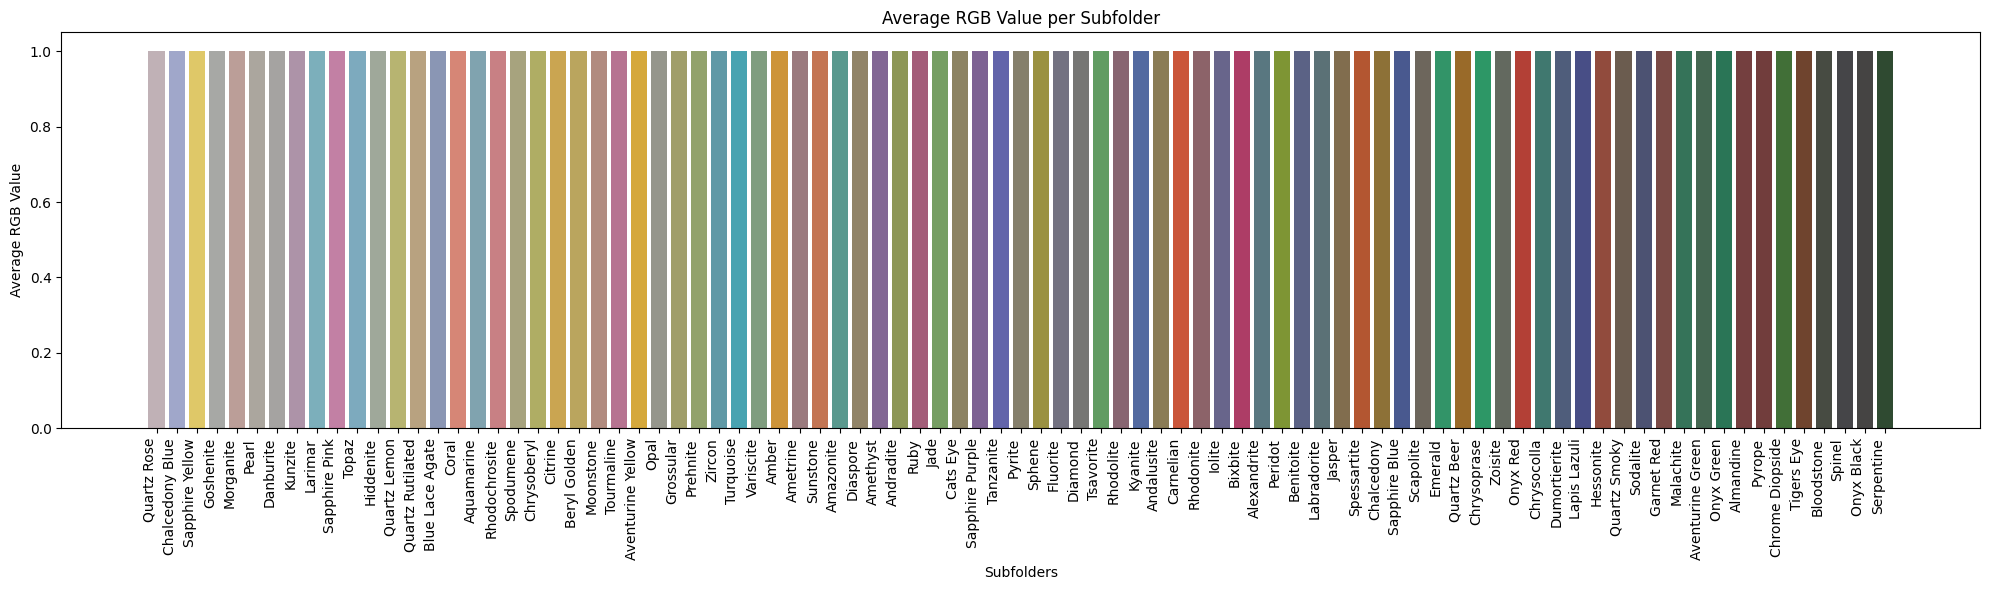

In [74]:
analyze_subfolder_statistics2(directorytrain)

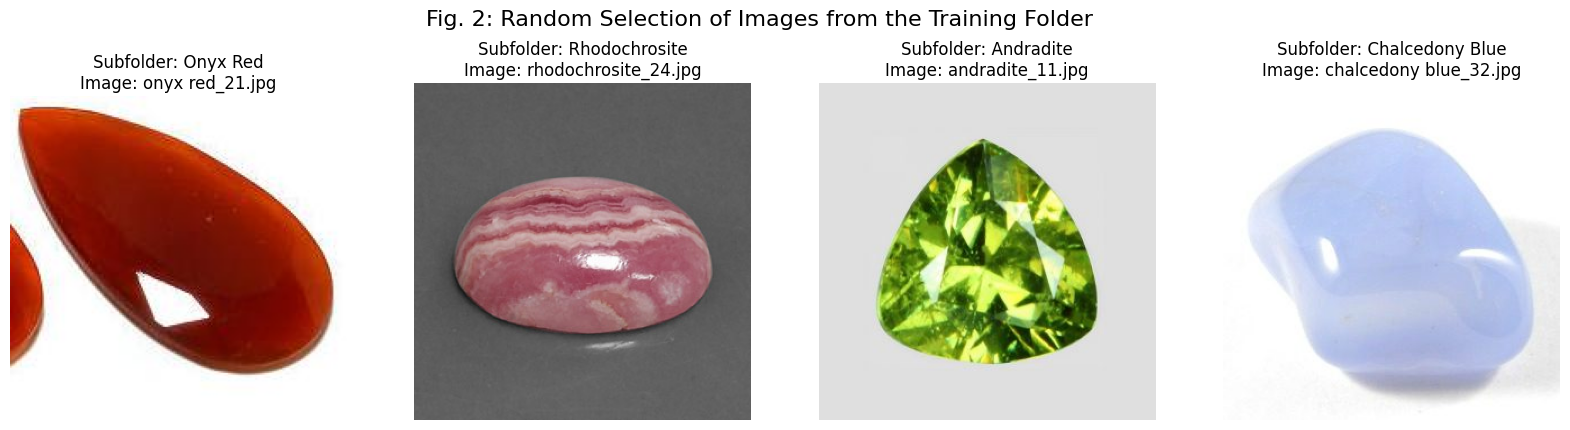

In [67]:
# Get a list of all subfolders in the directory
subfolders = [f.name for f in os.scandir(directorytrain) if f.is_dir()]

# Select 4 random subfolders
selected_subfolders = random.sample(subfolders, min(4, len(subfolders)))

# Create a figure and axes for the images
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Fig. 2: Random Selection of Images from the Training Folder', fontsize=16)

# Loop through the selected subfolders and display one random image from each
for i, subfolder in enumerate(selected_subfolders):
    subfolder_path = os.path.join(directorytrain, subfolder)
    image_files = [f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if image_files:
        random_image = random.choice(image_files)
        image_path = os.path.join(subfolder_path, random_image)
        img = mpimg.imread(image_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Subfolder: {subfolder}\nImage: {random_image}")
        axes[i].axis('off') # Hide axis ticks and labels
    else:
        axes[i].text(0.5, 0.5, f"No images in {subfolder}", ha='center', va='center')
        axes[i].axis('off')


plt.show()

A pixel correlation matrix was also completed, but it did not reveal any patterns that would be visually helpful.  But one example of exploratory image analysis might be interesting to know all those that have the most blue.

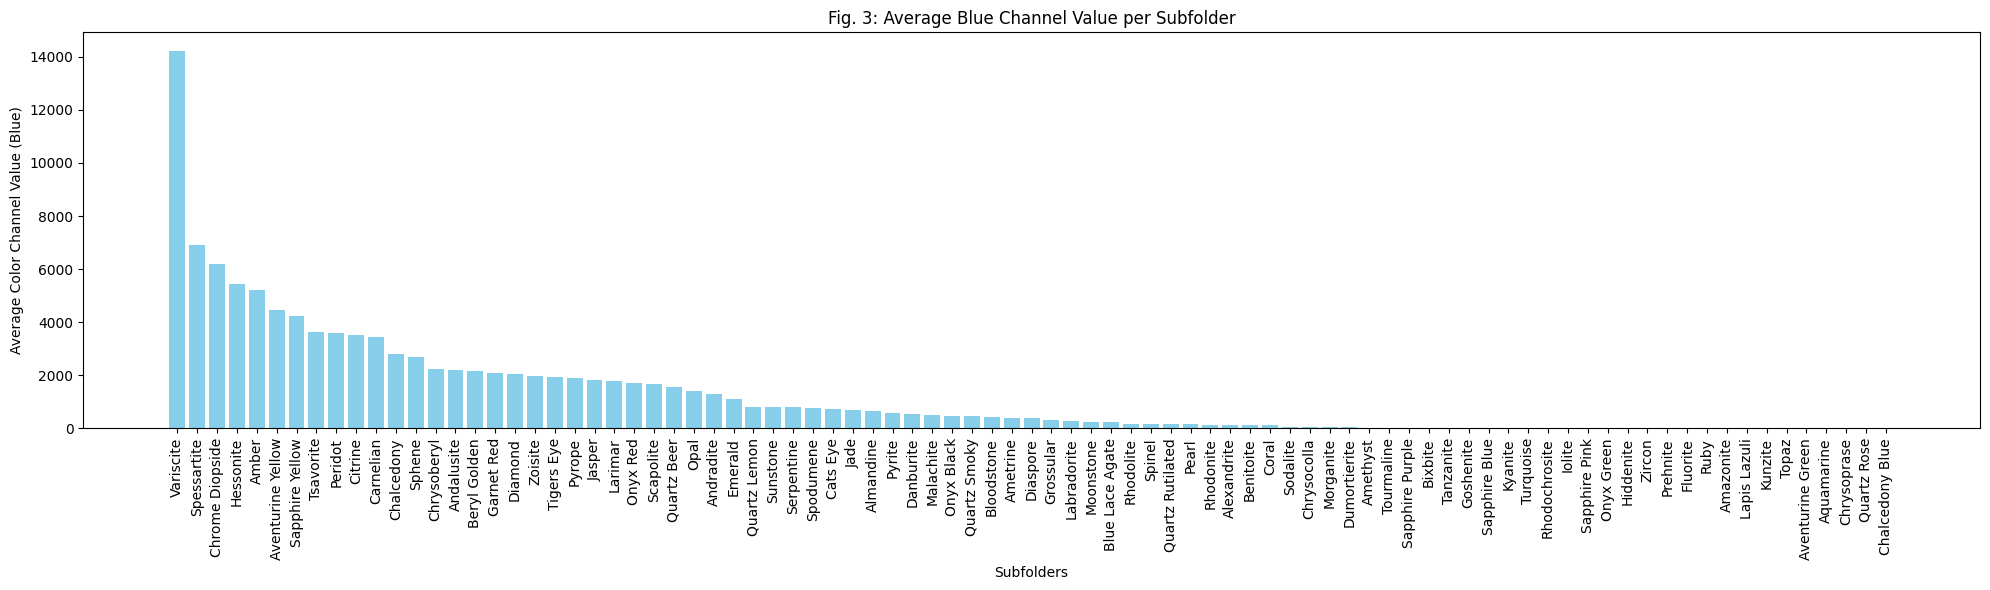

In [68]:
def analyze_subfolder_statistics(directory):
    """Calculates image statistics for each subfolder and displays color channel averages in a histogram.

    Args:
        directory: Path to the directory containing subfolders.
    """

    subfolder_statistics = {}

    for subfolder_name in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder_name)
        if os.path.isdir(subfolder_path):
            means = []
            std_devs = []
            color_histograms = []

            for filename in os.listdir(subfolder_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(subfolder_path, filename)
                    image = cv2.imread(image_path)

                    means.append(np.mean(image))
                    std_devs.append(np.std(image))
                    color_histograms.append(cv2.calcHist([image], [0], None, [256], [0, 256]))  # Blue channel

            subfolder_statistics[subfolder_name] = {
                "avg_mean": np.mean(means),
                "avg_std_dev": np.mean(std_devs),
                "avg_color_histogram": np.mean(color_histograms, axis=0)  # Average color histogram
            }

    # Sort subfolders by average color channel value in decreasing order
    sorted_subfolders = sorted(subfolder_statistics.items(), key=lambda x: x[1]["avg_color_histogram"][0], reverse=True)

    # Display color channel averages in a histogram
    subfolder_names = [item[0] for item in sorted_subfolders]
    avg_color_channels = [item[1]["avg_color_histogram"][0].item() for item in sorted_subfolders]  # Blue channel average

    plt.figure(figsize=(20, 6))  # Adjust figure size as needed
    plt.bar(subfolder_names, avg_color_channels, color='skyblue')
    plt.xlabel("Subfolders")
    plt.ylabel("Average Color Channel Value (Blue)")
    plt.title("Fig. 3: Average Blue Channel Value per Subfolder")
    plt.xticks(rotation=90, ha='center')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

directory = directorytrain
analyze_subfolder_statistics(directory)

So I would interpret this to mean that a random example jpg from variscite, spessartite, chrome diopside, hessonite, and amber would have some blue? Would that be right?

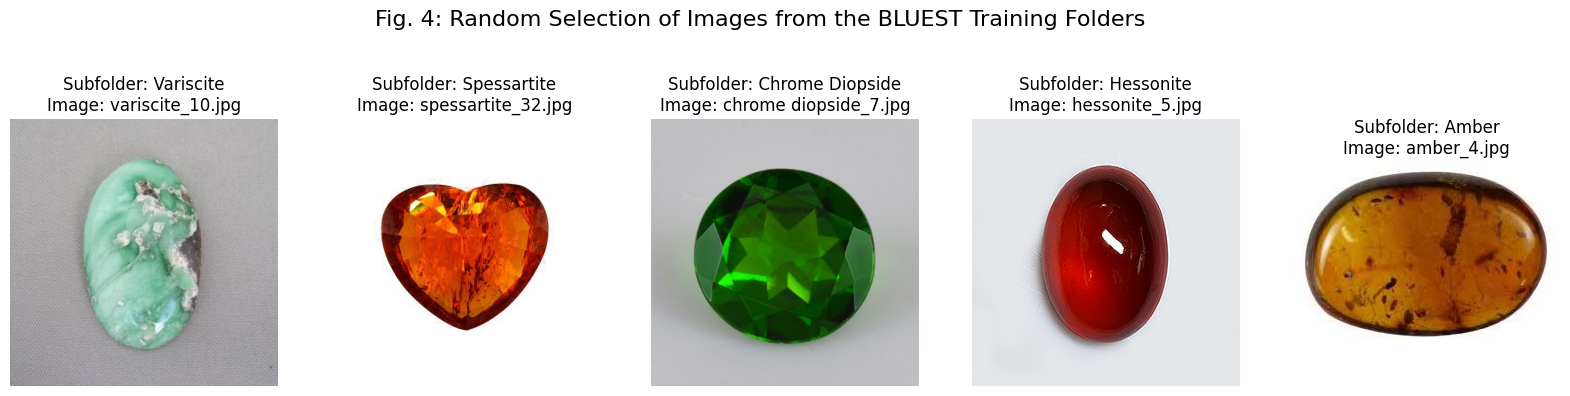

In [69]:
# show a random example of jpg from variscite, spessartite, chrome diopside, hessonite, and amber subfolders in directorytrain to visually verify blue
subfolders = ['Variscite', 'Spessartite', 'Chrome Diopside', 'Hessonite', 'Amber']

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Fig. 4: Random Selection of Images from the BLUEST Training Folders', fontsize=16)

for i, subfolder in enumerate(subfolders):
    subfolder_path = os.path.join(directorytrain, subfolder)
    image_files = [f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if image_files:
        random_image = random.choice(image_files)
        image_path = os.path.join(subfolder_path, random_image)
        try:
            img = mpimg.imread(image_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Subfolder: {subfolder}\nImage: {random_image}")
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            axes[i].text(0.5, 0.5, f"Error loading image", ha='center', va='center')
            axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, f"No images in {subfolder}", ha='center', va='center')
        axes[i].axis('off')

plt.show()

That is not really the case with this random selector. Could this be because of the backgrounds of the image?  Or is the average color really blue for these?

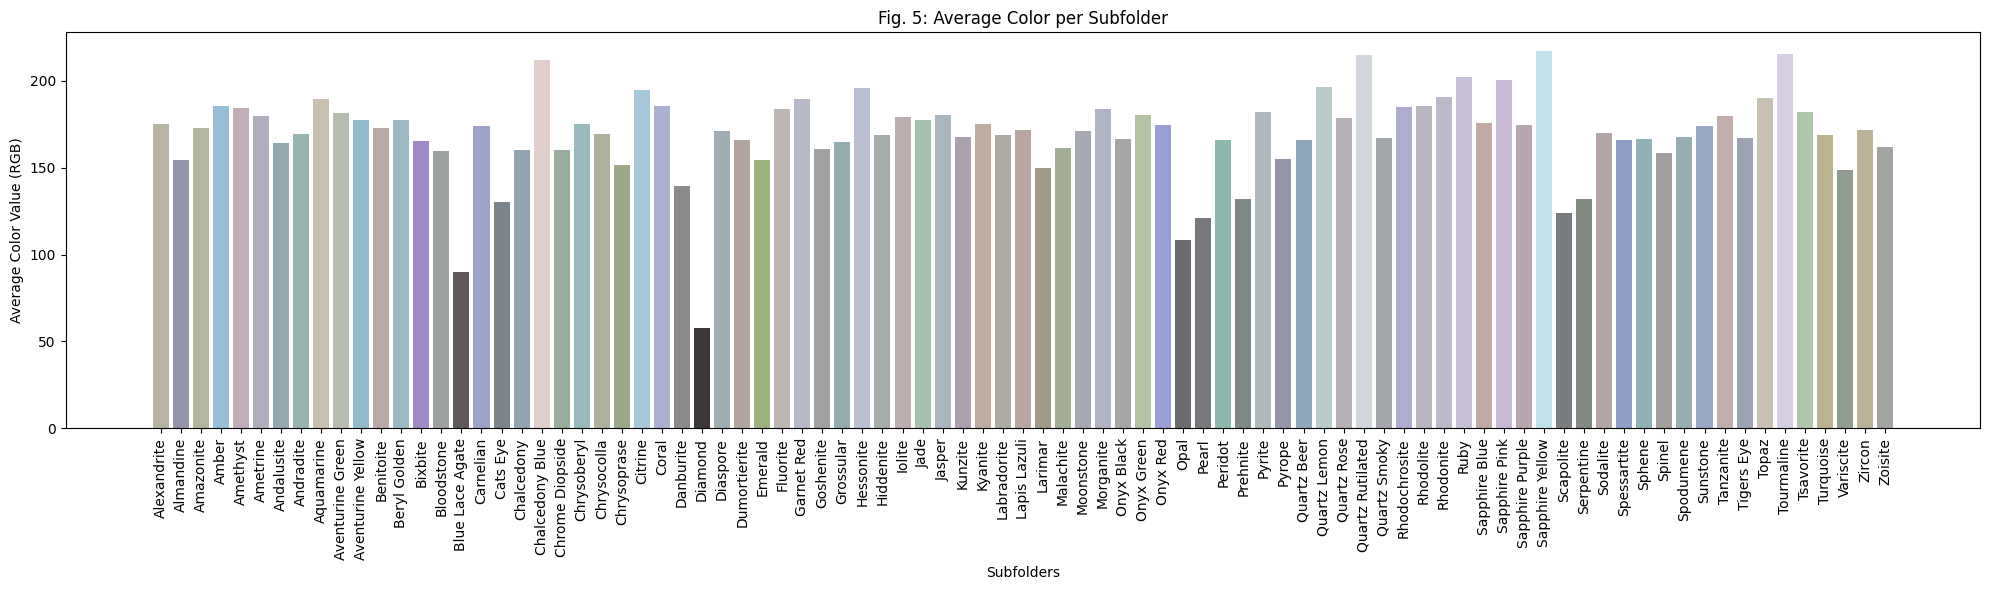

In [70]:
def analyze_subfolder_colors(directory):
    """
    Calculates the average color for all images within each subfolder
    and displays a histogram with the average color RGB value as the bar color.

    Args:
        directory: Path to the directory containing subfolders.
    """

    subfolder_colors = {}

    for subfolder_name in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder_name)
        if os.path.isdir(subfolder_path):
            average_colors = []

            for filename in os.listdir(subfolder_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(subfolder_path, filename)
                    image = cv2.imread(image_path)

                    # Calculate average color for the image
                    average_color = np.mean(image, axis=(0, 1))
                    average_colors.append(average_color)

            # Calculate average color for the subfolder
            subfolder_avg_color = np.mean(average_colors, axis=0) if average_colors else [0, 0, 0]  # Handle empty subfolders
            subfolder_colors[subfolder_name] = subfolder_avg_color

    # Sort subfolders alphabetically
    sorted_subfolders = sorted(subfolder_colors.keys())
    sorted_avg_colors_rgb = [subfolder_colors[subfolder] for subfolder in sorted_subfolders]

    # Convert RGB to hex for bar colors
    bar_colors = [to_hex(color / 255) for color in sorted_avg_colors_rgb]  # Normalize to 0-1 range

    plt.figure(figsize=(20, 6))
    plt.bar(sorted_subfolders, [np.mean(color) for color in sorted_avg_colors_rgb], color=bar_colors)  # Use average color as bar color
    plt.xlabel("Subfolders")
    plt.ylabel("Average Color Value (RGB)")
    plt.title("Fig. 5: Average Color per Subfolder")
    plt.xticks(rotation=90, ha='center')
    plt.tight_layout()
    plt.show()

directory = directorytrain
analyze_subfolder_colors(directory)

These look more muted than expected - but they all also have a bluer tint that expected too.  This may occur because the jpg analysis includes the background colors (white, black, gray). This may be important.  But before the backgrounds are further considered, let's evaluate the image size by reviewing the data as a scatter plot.  For example, look at diamond.  This looks like it is heavily weighted by black.

I attempted many methods of removing the background from the photos, and while some appeared to have a result in the thumbnail of the image, the histogram interpretations did not reflect any change.  See images below.  

# Outputs of Background Removal Evaluation

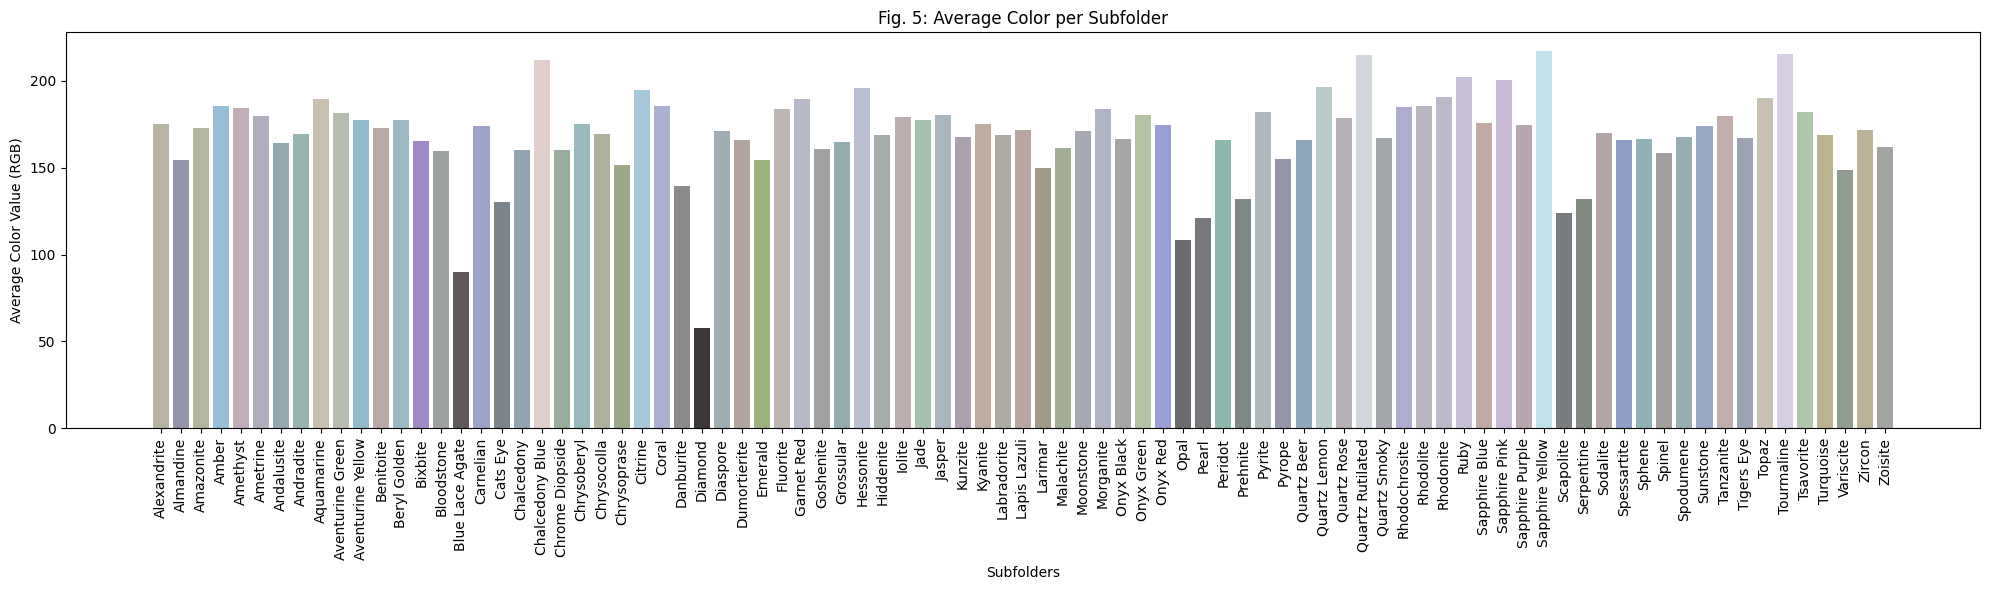

Since the histogram did not show any difference, I ran the code on the images directly to see if it made a difference on the actual images, and it does!  But why doesn't it affect the histogram calculation??

## Outputs of 2-Step Background Removal

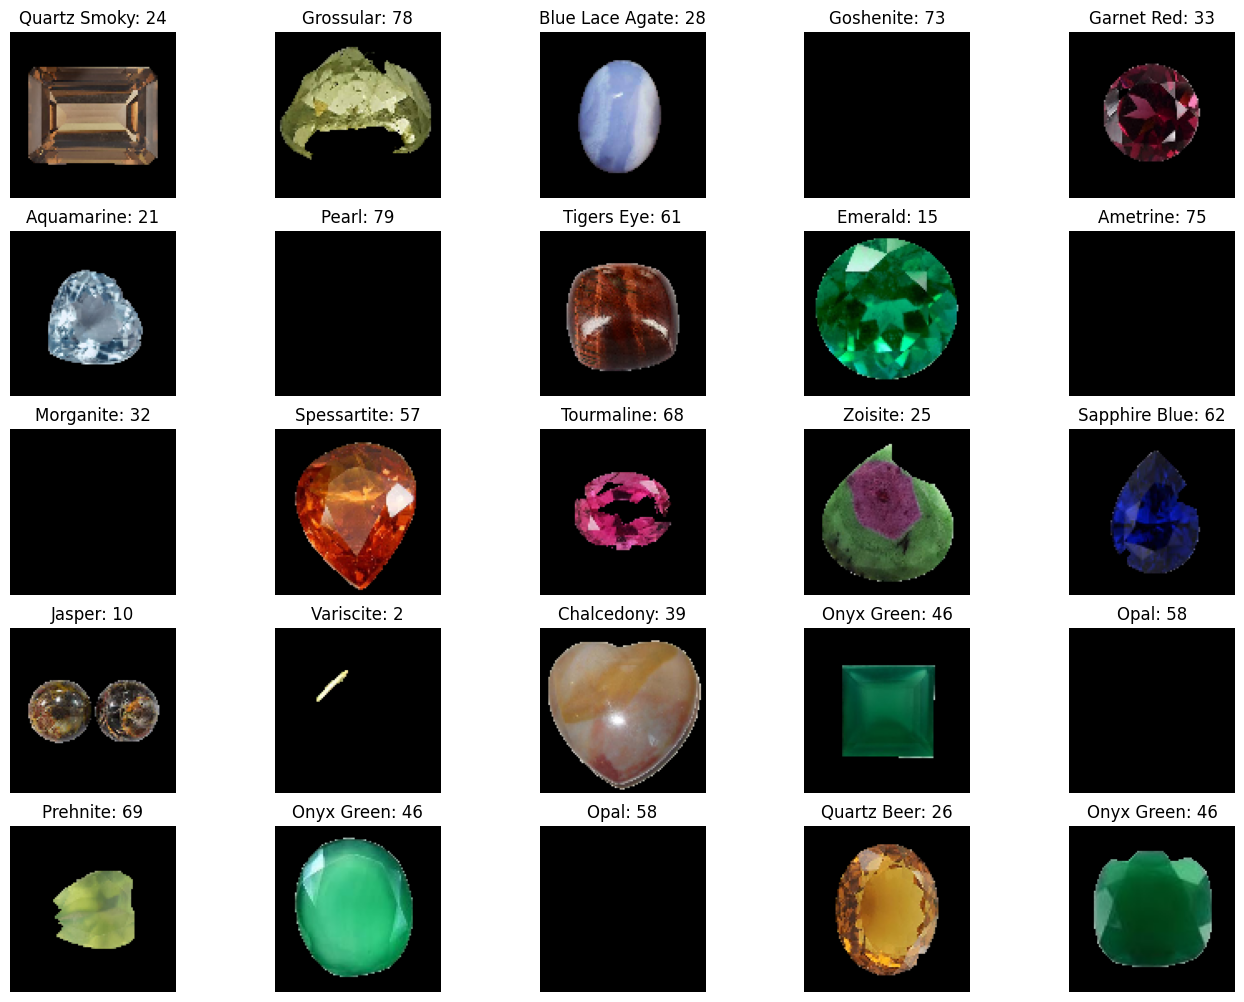

As you can see, the backgrounds have all been turned to black (but not no data). So I attempted a variety of morphological methods to remove the background effectively while preserving the object.  I tried to just convert to grayscale, then removing the background, then using canny edge detection, including adjustment of the canny thresholds up and down.  But nothing worked consistently well. I tried using grabCut, and adjusted rect (lower number = default was 10, tried 20, worse, tried 40 even worse, tried 5 worse) and iter_count to be higher, which resulted in longer processing, but no better results.  Ultimately, I could not find a method that adequately removed the backgrounds enough to proceed with that method.  As there were still minerals that were still completely masked.  I did one last round that included a mask for objects that were more blue as I noticed that many of the features that were completely masked above were blue tones (Sodalite, Chrysocolla, and Aquamarine).  I then tried to add a Kmeans clustering to remove the background prior to the grabCut and edge detection.  I noticed that as I increased the clusters (to allow for variation in the objects colors and brilliance), the background removal seemed more effective.  

When I ran another histogram based on the RGB values, you can see that the averages now favor dark to black colors.  

##Outputs of Final Histogram with Background "Removed" from 2-Step Process

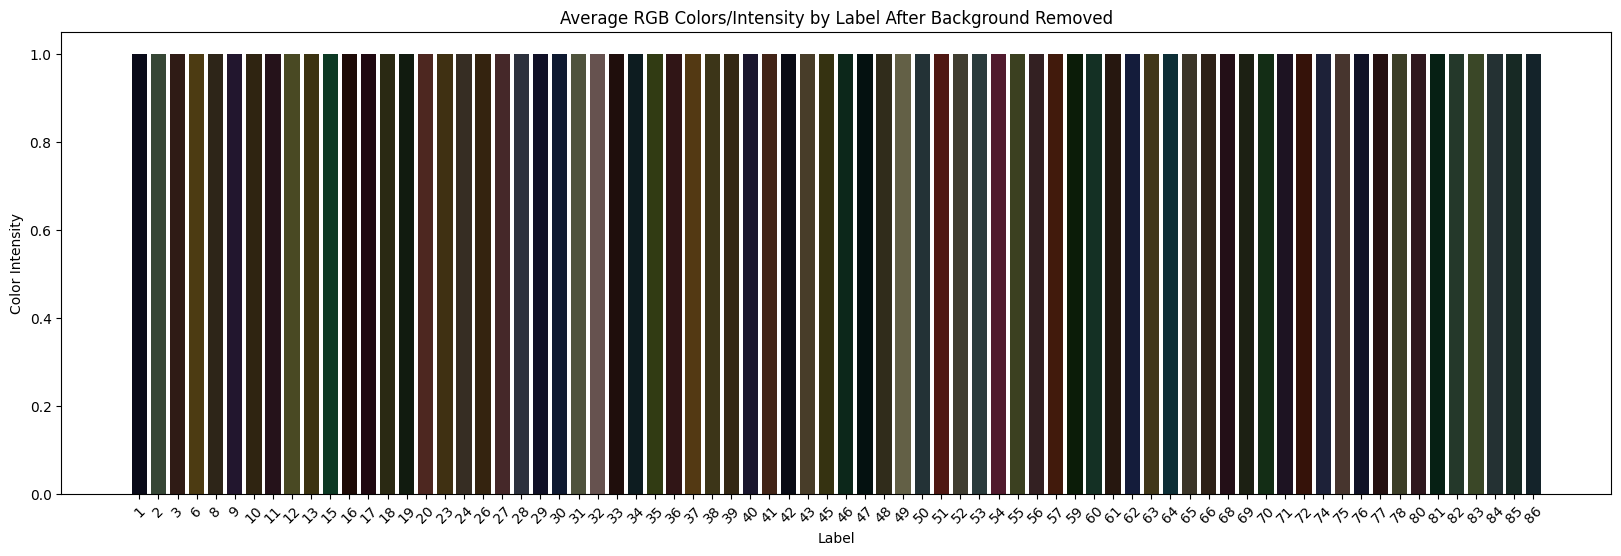







As seen, the histogram is now much darker, likely due to the influence the the "blackening" of the background.  However, I did not want it to include the black in the average RGB color calculation.  But no matter the code that I used, I could not effectively get the code to remove the background to "no data".  So in summary, lthough the background of the image definitely seems to play an part in the distribution of pixels, it was not clear how to effectively remove it from the classification evaluation.  Additionally, I could not get it to be completely effective for every mineral type. After many hours of trial and error, I parked this concept for future research.

My thought was that the background may play a role in the accuracy and loss of the predictions. Then a collegue recommended that I should try cropping the image to a smaller size to remove the background in that way.  


In [71]:
from PIL import Image

def read_images():
    Images, Labels = [], []
    for root, dirs, files in os.walk(directory):
        f = os.path.basename(root)
        for file in files:
            Labels.append(f)
            try:
                image = cv2.imread(root+'/'+file)              # read the image (OpenCV)
                # Get image dimensions
                height, width, _ = image.shape
                # Calculate center coordinates for cropping
                center_x = width // 2
                center_y = height // 2
                # Calculate cropping dimensions (half of original size)
                crop_width = width // 2
                crop_height = height // 2
                # Crop the image
                cropped_image = image[center_y - crop_height // 2:center_y + crop_height // 2,
                                     center_x - crop_width // 2:center_x + crop_width // 2]
                # Resize the cropped image to 100x100
                resized_image = cv2.resize(cropped_image,(int(img_w), int(img_h)))
                # Convert the image from BGR to RGB
                image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
                Images.append(image_rgb)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    return (Images,Labels)

In [72]:
def analyze_subfolder_colors(directory):
    """
    Calculates the average color for all images within each subfolder
    and displays a histogram with the average color RGB value as the bar color.

    Args:
        directory: Path to the directory containing subfolders.
    """

    subfolder_colors = {}

    for subfolder_name in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder_name)
        if os.path.isdir(subfolder_path):
            average_colors = []

            for filename in os.listdir(subfolder_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(subfolder_path, filename)
                    image = cv2.imread(image_path)

                    # Calculate average color for the image
                    average_color = np.mean(image, axis=(0, 1))
                    average_colors.append(average_color)

            # Calculate average color for the subfolder
            subfolder_avg_color = np.mean(average_colors, axis=0) if average_colors else [0, 0, 0]  # Handle empty subfolders
            subfolder_colors[subfolder_name] = subfolder_avg_color

    # Sort subfolders alphabetically
    sorted_subfolders = sorted(subfolder_colors.keys())
    sorted_avg_colors_rgb = [subfolder_colors[subfolder] for subfolder in sorted_subfolders]

    # Convert RGB to hex for bar colors
    bar_colors = [to_hex(color / 255) for color in sorted_avg_colors_rgb]  # Normalize to 0-1 range

    plt.figure(figsize=(20, 6))
    plt.bar(sorted_subfolders, [np.mean(color) for color in sorted_avg_colors_rgb], color=bar_colors)  # Use average color as bar color
    plt.xlabel("Subfolders")
    plt.ylabel("Average Color Value (RGB)")
    plt.title("Fig. 5: Average Color per Subfolder")
    plt.xticks(rotation=90, ha='center')
    plt.tight_layout()
    plt.show()

directorycropped = cropped_resized_images
analyze_subfolder_colors(directorycropped)

NameError: name 'cropped_resized_images' is not defined

Until this issue is better understood and addressed, the native color files will be used for various machine learning methods to compare accuracy and loss.

## Machine Learning:

The first step for every supervised classification task is to split the data into a training group and a testing group.  In this case, the dataset was already split into training and testing groups in Kaggle.  However, it appears that a random selection from each mineral was pulled as there is general consistency that approximately 4 samples were chosen from each mineral group.  This is similar to stratified splitting where splitting is based on defined groups.  

Two different classifciation methods were evaluated:  A Convolutional Neural Network (CNN) and a Sequential model using TensorFlow and Keras.

##Convolutional Neural Network (CNN)

To prepare the data for the model, we will make sure that the image size is defined to 100 x 100 pixels.  Then for this model, the images will be converted to PyTorch tensors, and normalizes the pixel values between 0 and 1.  However, then they are further normalized by the mean and standard deviation of each of the color bands (Red, Green, and Blue).

The training dataset is randomly split for validation.  But the test dataset was not randomly selected.  Those were randomly selected from each subfolder.  So a consistent number of images was retained in the Kaggle-provided test folder since a random selection across all subfolders may introduce leaking, bias, and may result in unrealistically high performance of the model.  

In [ ]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(directorytrain, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
test_transform = transforms.Compose([
   transforms.Resize((100, 100)),
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(directorytest, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class GemCNN(nn.Module):
   def __init__(self, num_classes):
       super().__init__()
       self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
       self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
       self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
       self.pool = nn.MaxPool2d(2, 2)
       self.fc1 = nn.Linear(64 * 12 * 12, 512)
       self.fc2 = nn.Linear(512, num_classes)
       self.relu = nn.ReLU()

   def forward(self, x):
       x = self.pool(self.relu(self.conv1(x)))
       x = self.pool(self.relu(self.conv2(x)))
       x = self.pool(self.relu(self.conv3(x)))
       x = x.view(-1, 64 * 12 * 12)
       x = self.relu(self.fc1(x))
       x = self.fc2(x)
       return x

In [ ]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')
model = GemCNN(len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop with loss tracking
num_epochs = 20
train_losses = []
epoch_losses = []

for epoch in range(num_epochs):
   model.train()
   running_loss = 0.0

   for images, labels in train_loader:
       images, labels = images.to(device), labels.to(device)
       optimizer.zero_grad()
       outputs = model(images)
       loss = criterion(outputs, labels)
       loss.backward()
       optimizer.step()

       running_loss += loss.item()
       train_losses.append(loss.item())

   epoch_loss = running_loss / len(train_loader)
   epoch_losses.append(epoch_loss)
   print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


In [ ]:
# Plot losses
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title('Batch Losses')
plt.xlabel('Batch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(epoch_losses)
plt.title('Epoch Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [ ]:
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

model.eval()
dataiter = iter(test_loader)
images, labels = next(dataiter)

with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs.cpu(), 1)

# Shuffle indices
indices = np.arange(len(images))
np.random.shuffle(indices)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx in range(10):
    ax = axes[idx//5, idx%5]
    ax.imshow(imshow(images[indices[idx]]))
    ax.set_title(f'Pred: {test_dataset.classes[predicted[indices[idx]]]}\nTrue: {test_dataset.classes[labels[indices[idx]]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

Have some fun, re-clicking on the code above to see how the prediction did, and to see some cool examples of gemstones!

In [ ]:
# Switch model to evaluation mode
model.eval()

# Collect all predictions and true labels
all_labels = []
all_predictions = []
correct = 0  # Initialize correct predictions count
total = 0  # Initialize total predictions count

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Update correct and total counts
        total += labels.size(0)  # Increment total by batch size
        correct += (predicted == labels).sum().item()  # Increment correct by num of correct in batch

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Compute confusion matrix
all_classes = np.arange(len(test_dataset.classes))
cm = confusion_matrix(all_labels, all_predictions, labels=all_classes)

# ... (Rest of the code for plotting confusion matrix remains the same) ...

# Calculate accuracy
test_accuracy = 100 * correct / total # Use the accumulated correct and total
print(f'Test Accuracy: {test_accuracy:.2f}%')


# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f'F1 Score: {f1:.4f}')


So for this first CNN model, the Test Accuracy: 54.55% and the F1 Score: 0.52.  There are several things that could be done to improve the score including augmenting the data to include transformed images (which we will do in the next model).  Also, the model hyperparameters including learning rates and batch sizes could be adjusted.  

## Keras Models

In this example, we are using a Sequential model which is a stack of layers.  We will start with a convolutional 2D model, that uses 32 filters (kernels).  This will produce 32 different image maps.  The kernel size is a 3x3 window which will slide over the entire image and break it down bit by bit. The input shape matches the revised image size of 100x100, and the 3 stands for the 3 color channels (Red, Green, and Blue). Relu activation introduces non-linearity to the model, and padding makes sure that the output 32 feature maps have the same height and width (100 x 100) by adding zeros.

Next, we will use a max pooling layer to reduce the spatial dimensions of the feature maps by half (downsampling).  This will reduce the complexity.

In [ ]:
# Read the images and labels from the training set

Train_Imgs, Train_Lbls = read_images()
Train_Lbls = get_class_index(Train_Lbls)
print('Shape of train images: {}'.format(Train_Imgs.shape))
print('Shape of train labels: {}'.format(Train_Lbls.shape))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Train_Imgs, Train_Lbls, shuffle = True, test_size = 0.2, random_state = 42)
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Input

model = Sequential()
model.add(Input(shape=(100, 100, 3)))  # Add Input layer as the first layer

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(len(Name)))
model.add(Activation('softmax'))

model.summary()

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

One way you can improve classification is to replicate and slightly tweak your input images by rotating, moving the view around within the 100x100 frame, shifting the width or height, zooming, or flipping them.  This can multiply your number of images by however many variations you choose.  For example rotating on the 90, 180, 270, and flipping each variant can increase the number of images by a factor of 8.  The validation split and the val_datagen reserve part of the original training data for validation, and will not be copied and changed in order to provide a consistent, more reliable measure of the model performance.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(vertical_flip=True,
                                horizontal_flip=True,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.1,
                                validation_split=0.2)

val_datagen = ImageDataGenerator()

In [ ]:
batch_size = 32

In [ ]:
n = randint(0,len(X_train))
samples = np.expand_dims(X_train[n], 0)
it = train_datagen.flow(samples, batch_size=batch_size)
cols = 7

fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(15, 10))
ax[0].imshow(X_train[n], cmap='gray')
ax[0].set_title('Original', fontsize=10)

for i in range(1,cols):
    batch = next(it)    # generate batch of images using next(it) instead of it.next()
    image = batch[0].astype('uint32') # convert to unsigned int for viewing
    ax[i].set_title('augmented {}'.format(i), fontsize=10)
    ax[i].imshow(image, cmap='gray')

Thes tranformation augmentations may help out the model to predict better.

In [ ]:
train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_gen = val_datagen.flow(X_val, y_val, batch_size=batch_size)

EPOCHS = 20
iter_per_epoch = len(X_train) // batch_size
val_per_epoch = len(X_val) // batch_size

m = model.fit(
       train_gen,
       steps_per_epoch= iter_per_epoch,
       epochs=EPOCHS,
       validation_data = val_gen,
       validation_steps = val_per_epoch,
       verbose = 1
       )

# Predict on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Calculate overall accuracy
accuracy = accuracy_score(y_val, y_pred_classes)

# Calculate macro F1 score (average F1 score across all classes)
f1 = f1_score(y_val, y_pred_classes, average='macro')

# Print the results
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Macro F1 Score: {f1:.4f}")

In [ ]:
# Plot
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model loss')
plt.show()

plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model accuracy')
plt.show()

In [ ]:
def read_imagest():
    Images, Labels = [], []
    # Check if the path exists before proceeding
    test_dir = os.path.join(gemstones_images_path, 'test')  # Use os.path.join
    if not os.path.exists(test_dir):
        print(f"Error: Test directory not found: {test_dir}")
        return (np.array([]), np.array([]))

    for root, dirs, files in os.walk(test_dir):
        print(root, dirs, files) # Print for debugging
        f = os.path.basename(root)
        for file in files:
            Labels.append(f)
            try:
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Error: Could not read image: {image_path}")
                    continue
                image = cv2.resize(image,(int(img_w), int(img_h)))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                Images.append(image)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    return (Images,Labels)

In [ ]:
Test_Imgs, Test_Lbls = read_imagest()
Test_Lbls = get_class_index(Test_Lbls)

In [ ]:
f,ax = plt.subplots(5,5)
f.subplots_adjust(0,0,2,2)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Test_Imgs))
        pred_image = np.array([Test_Imgs[rnd_number]])
        pred_class = np.argmax(model.predict(pred_image)[0], axis=-1)
        pred_prob = model.predict(pred_image).reshape(-1)
        act =Name[Test_Lbls[rnd_number]]
        ax[i,j].imshow(Test_Imgs[rnd_number])
        ax[i,j].imshow(pred_image[0])
        if(Name[pred_class] != Name[Test_Lbls[rnd_number]]):
            t = '{} [{}]'.format(Name[pred_class], Name[Test_Lbls[rnd_number]])
            ax[i,j].set_title(t, fontdict={'color': 'darkred'})
        else:
            t = '[OK] {}'.format(Name[pred_class])
            ax[i,j].set_title(t)
        ax[i,j].axis('off')

So, one can very quickly see that the second model did not produce as accurate results. By Epoch 20, the second model had still only an accuracy: 0.28, meaning the model correctly predicted the outcome 28% of the time, and a loss: 1.83, meaning the model predictions are very far off from the actual values. Remember that validation portion, the ones the the model had never seen? The accuracy of prediction on that set was 0.31 (31%) and loss: 2.16.  This high loss suggests that the model is not generalizing well, and the data may be overfit.  The Overall Accuracy was 0.36 and the F1 Score was 0.30.

You can also see in the visual comparison, less than half were identified correctly.  This may mean that the model needs more epochs.  But more epochs requires more time.  This is part of the trade off.  How accurate does the model need to be for the specific study area?  Would it be helpful to run a confusion matrix to identify false positives/false negatives?  

In [ ]:
if 'model' in locals() and 'Test_Imgs' in locals() and 'Test_Lbls' in locals():
    y_pred = np.argmax(model.predict(Test_Imgs), axis=1)
    cm = confusion_matrix(Test_Lbls, y_pred)

    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap="Blues")  # Use imshow for plotting
    plt.title("Confusion Matrix (Keras)")
    plt.colorbar()

    tick_marks = np.arange(len(Name))
    plt.xticks(tick_marks, Name, rotation=90)
    plt.yticks(tick_marks, Name)

    # Add annotations (numbers inside the squares)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], "d"),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

else:
    print("Model or test data not found. Please ensure the model and test data are defined correctly.")

This shows us that some samples had better potential to be predicted right every time.  Peridot for example was predicted right 4 out of 4.  Jade on the other hand was misclassified all 4 times!

#Questions and Answers

**Which method did you like the most?**

I preferred the first CNN using Pytorch.  It seemed more simple and performed better.  I ran the first model using 80 epochs the first time, and it performed even better.  But the cost to benefit ratio may not always work for everyone, so I reduced it to 20 epochs for both for comparison.

**Which method did you like the least?**

The Keras method performed worse, and was more erratic. However, increasing the epochs does help the performance if you are willing to sacrifice time.  Also, I did like the idea of transforming the images to gain more data, but it did not seem to pay off in performance with the 20 epochs.  Additional hyperparameter tuning may result in better performance for the final evaluation.    

**How did you score these supervised models?**  

I scored both models using loss, accuracy, F1 score, and a confusion matrix.  For the CNN model, the model perfomance was Accuracy: 55% and the F1 Score: 0.52, and ror the Keras model, the accuracy was 36% and the F1 Score was 0.30.  The confusion matrix was helpful to see which images were often misclassified and could be used for image replacement.

**Did the output align with your geologic understanding?**

In general the models predicted well based primarily on color, and then looked for shape and other characteristics that were secondary.  When the colors were too close together, it seemed like the models predictions were not as accurate.  However, so many minerals have very similar colors based on their similar chemical structure that the success rate for image classification seems limited as compared to other image classification tasks.  

**Did you hyperparameter tune? Why or why not?**

Both models had slightly different hyperparameters that could be modified.  Although, I didn't apply grid search, I was interested in trying this in the next version.  For this first pass, I only evaluated the learning rate, batch size, and number of epochs, of which the latter had the most impact but also took the most time.

**How did you split your data? and why does that make sense for this dataset?**

The provider already split the data into training (approximately 88%) and testing (approximately 12%) datasets.  It appears that they used a combined method, first using a stratified method of selecting some images from each subfolder.  Then from the subfolders, the images were randomly selected which is appropriate for this type of image data if you want it to generalize to many of other images.  This does seem like a logical approach for this dataset since color is being used as the primary filter.  There is little other firm predictive information that could be used for these minerals since their shape, faceting, and other dimensions vary so much from image to image.

**What did you want to learn more about?**

I would like to be able to better remove the backgrounds of the image.  I feel confident that is playing a part in some of the predictions, however, I cannot confirm how at this point. I would also be interested in seeing how well a classifier does on raw minerals rather than minerals that had been faceted and polished.  

**Did you pre-process your data?**

The data was provided by Kaggle.  But I did attempt to remove the background.  But the background was basically tranformed into black pixels that would have made predictions more difficult. Therefore, the background-removed version was not modeled, but the examples of the processing have been retained the in code above.

**Do all models require pre-processing?**

For image classification, all models will require some pre-processing.  This may include resizing the images which was completed on both models, and data augmentation/transformations, which was only completed on the Keras model.  I also attempted converting the colors, and removing the background, but that was not modeled.     